In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA

In [2]:
m = nn.Softmax(dim = 1)
f = lambda x: torch.log(1e-20 + x)

# Generating data points


### 1. Randomly generate ground truth $\mathbf{M}$

We here generate a random ground truth $20\times 20$ matrix $\mathbf{M}$ whose first $5$ eigenvalues are $1,2,3,4,5$ and the rests are zero.

In [3]:
def M_generator(d, S):
    BB = torch.randn((d, d), dtype = torch.float64)
    MM = BB @ BB.T
    U_M, _, _ = LA.svd(MM.detach().numpy(), full_matrices=False)
    return U_M @ np.diag(S) @ U_M.T

In [4]:
S = torch.tensor([1e-7 for i in range(20)])

In [5]:
for i in range(5):
    S[i] = i+1

In [6]:
M_t = M_generator(d = 20, S = S)

In [7]:
_, s, _ = LA.svd(M_t, full_matrices=False)

### Using standard Gussian distribution to generate data, what is the average $\|\cdot\|^2_M$-norm of data points 

In [8]:
k_1 = 20
counter = 0
S = 0
SS = 0
for i in range(10000):
    x = torch.randn((k_1,), dtype = torch.float64)
    y = torch.randn((k_1,), dtype = torch.float64)
    S += (x-y) @ M_t @ M_t.T @ (x-y)/10000
    SS += (x-y) @ (x-y)/10000
#     if (x-y) @ M_t @ M_t.T @ (x-y)<100:
#         counter += 1
print(" average squared Euclidean norm = {}\n average squared M-norm = {}".format(SS.item(), S.item()))

 average squared Euclidean norm = 40.090501498429056
 average squared M-norm = 109.13133311695194


### Set treshold $\tau$

In [9]:
T = torch.tensor([70], dtype = torch.float64)
T

tensor([70.], dtype=torch.float64)

In [10]:
def ST(TT):
    t = TT.shape[0]
    T_ = torch.zeros(t + 1, dtype = torch.float64)
    for i in range(1,t+1):
        T_[i] = T_[i-1] + TT[i-1]
    return T_

In [11]:
ST(T)

tensor([ 0., 70.], dtype=torch.float64)

In [12]:
def prob(x, TT):
    N = TT.shape[0]+1
    T_ = ST(TT)
    W = x.reshape(-1,1) * torch.tensor([i for i in range(1,N+1)], dtype = torch.float64).reshape(1,-1) - T_.reshape(1,-1)
    return m(W)

In [13]:
def data_generator(n, k, d, n_train, T, M, noise = 0.05, random_labeling = True):

    X = torch.zeros((n, k), dtype = torch.float64)
    Y = torch.zeros((n, k), dtype = torch.float64)
    D = torch.zeros(n, dtype = torch.int64)
    D_no_noise = torch.zeros(n, dtype = torch.int64)
    c = 0
    ones = torch.ones(len(T)+1, dtype = torch.float64)
    
    while True:
        x = torch.randn((k,), dtype = torch.float64)
        y = torch.randn((k,), dtype = torch.float64)
        norm_2_M = (x-y) @ M @ M.T @ (x-y)
        
        
        weights = prob(norm_2_M, T).reshape(-1)
        if random_labeling:
            label = torch.multinomial(weights, 1).item()
        else:
            label = torch.argmax(weights).item()
                  
        D_no_noise[c] = label
        X[c] = x
        Y[c] = y
        if np.random.uniform() > noise:
            D[c] = label
        else:
            D[c] = torch.multinomial(ones, 1).item()
        c+= 1
            
        if c == n:
            return train_test_split(X, Y, D, D_no_noise, n_train) 

In [14]:
def train_test_split(X, Y, D, D_no_noise, n_train):
    n, k = X.shape
    
    X_T, Y_T, D_T = X[:n_train], Y[:n_train], D[:n_train]
    X_test, Y_test, D_test = X[n_train:], Y[n_train:], D[n_train:]
    D_no_noise_test = D_no_noise[n_train:]
    D_no_noise_T = D_no_noise[:n_train]
    
    return X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test

In [15]:
def M_distance (X, Y, A):
    return ((X - Y) @ A).square().sum(axis = 1)

In [16]:
def pred(x, y, B, T):
    dis = ((x - y) @ B).square().sum(axis = 1)
    N = T.shape[0]+1
    T_ = ST(T)
    W = dis.reshape(-1,1) * torch.tensor([i for i in range(1,N+1)], 
                                         dtype = torch.float64).reshape(1,-1) - T_.reshape(1,-1)
    return torch.argmax(W, dim=1)

In [17]:
def loss(X, Y, L, B, Tau):
    S = ((X - Y) @ B).square().sum(axis = 1)
    P = prob(S, Tau)
    Scores = -torch.log(1e-30 + P[range(P.shape[0]), L]) #- Tau[Tau<0].sum()
    return Scores.mean()

In [18]:
def train(X, Y, L, d, k, learning_rate = 5e-1, n_iters = 30000, decay = 1, l = 7):
    
    train_acc_history_noisy = []
    train_acc_history = []
    test_acc_history_noisy = []
    test_acc_history = []
    
    X = X.requires_grad_(False)
    Y = Y.requires_grad_(False)
    L = L.requires_grad_(False)
    
    B = (1e-6 * torch.randn((k,d), dtype = torch.float64)).clone().detach().requires_grad_(True)
    # Tau  = (1e-5 * torch.arange(7, dtype = torch.float64)).clone().detach().requires_grad_(True)
    Tau  = (1e-5 * torch.zeros(len(T), dtype = torch.float64)).clone().detach().requires_grad_(True)
    
    for epoch in range(n_iters):
        l = loss(X, Y, L, B, Tau)
        # calculate gradients = backward pass
        l.backward()

        # update weights
        with torch.no_grad():
            B -= learning_rate * B.grad
            Tau -= learning_rate * Tau.grad
            
            
        # zero the gradients after updating
        
        if epoch % 500 == 0:
            print(f'epoch {epoch+1}:\n norm of M.grad = {B.grad.square().sum()},\n loss = {l.item()}')
            print(Tau)
            with torch.no_grad():
                
                Pred_T = pred(X_T, Y_T, B, Tau)
                e = (Pred_T == D_T).sum()/D_T.shape[0]
                train_acc_history_noisy.append(e)
                
                P = pred(X_T, Y_T, B, Tau)
                e = (P == D_no_noise_T).sum()/D_no_noise_T.shape[0]
                train_acc_history.append(e)
                
                P = pred(X_test, Y_test, B, Tau)
                e = (P == D_test).sum()/D_test.shape[0]
                test_acc_history_noisy.append(e)
                
                P = pred(X_test, Y_test, B, Tau)
                e = (P == D_no_noise_test).sum()/D_no_noise_test.shape[0]
                test_acc_history.append(e)

                learning_rate *= decay
        
        B.grad.zero_()
        Tau.grad.zero_()
    return B, Tau, train_acc_history_noisy, train_acc_history, test_acc_history_noisy, test_acc_history

### d = 20, noise = 0.1

In [19]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = data_generator(n = 50000, 
                                                                                               k = 20, 
                                                                                               d = 20, 
                                                                                               n_train = 45000, 
                                                                                               T = T, 
                                                                                               M = M_t,
                                                                                               random_labeling = False, 
                                                                                               noise = 0.1)

In [20]:
A, T, train_acc_noisy, train_acc, test_acc_noisy, test_acc = train(X_T, 
                                                                   Y_T, 
                                                                   D_T, 
                                                                   d = 20, 
                                                                   k = 20, 
                                                                   learning_rate = 5e-2, 
                                                                   n_iters = 10001, 
                                                                   decay = .98)

epoch 1:
 M = 1.3401961966086953e-10,
 loss = 0.6931471804645638
tensor([-0.0044], dtype=torch.float64, requires_grad=True)
epoch 501:
 M = 0.0005202668687958235,
 loss = 0.43407791282519254
tensor([0.9823], dtype=torch.float64, requires_grad=True)
epoch 1001:
 M = 0.000532333834910922,
 loss = 0.3792799502579153
tensor([2.0398], dtype=torch.float64, requires_grad=True)
epoch 1501:
 M = 1.8302494821029463e-05,
 loss = 0.35755480634816506
tensor([2.6247], dtype=torch.float64, requires_grad=True)
epoch 2001:
 M = 6.194036109363872e-06,
 loss = 0.35198261617333043
tensor([2.9711], dtype=torch.float64, requires_grad=True)
epoch 2501:
 M = 2.477070946338826e-06,
 loss = 0.3498500864915216
tensor([3.1841], dtype=torch.float64, requires_grad=True)
epoch 3001:
 M = 1.0924257796796676e-06,
 loss = 0.34894134509776564
tensor([3.3220], dtype=torch.float64, requires_grad=True)
epoch 3501:
 M = 5.136119408370831e-07,
 loss = 0.3485268575502796
tensor([3.4144], dtype=torch.float64, requires_grad=Tru

In [21]:
I = [i for i in range(0,10001, +500)]

In [22]:
len(train_acc_noisy)

21

In [23]:
len(I)

21

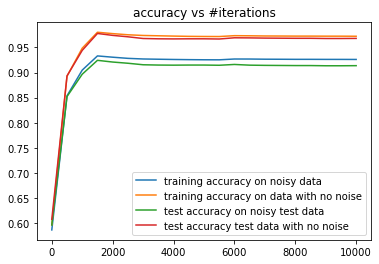

In [24]:
plt.plot(I, train_acc_noisy, label = 'training accuracy on noisy data')
plt.plot(I, train_acc, label = 'training accuracy on data with no noise')
plt.plot(I, test_acc_noisy, label = 'test accuracy on noisy test data')
plt.plot(I, test_acc, label = 'test accuracy test data with no noise')
plt.title("accuracy vs #iterations", color='black') 
plt.legend()
plt.show()

### d = 50, noise = 0.05
Only the fisrt 10 eigenvalue of $M$ are nonzero which are $[2,4,\ldots,20]$.

In [25]:
s = torch.tensor([0 for i in range(50)])
for i in range(10):
    s[i] = 2*(i+1)

In [26]:
s

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [27]:
M_t = M_generator(d = 50, S = s)

In [28]:
k_1 = 50
counter = 0
S = 0
SS = 0
for i in range(10000):
    x = torch.randn((k_1,), dtype = torch.float64)
    y = torch.randn((k_1,), dtype = torch.float64)
    S += (x-y) @ M_t @ M_t.T @ (x-y)/10000
    SS += (x-y) @ (x-y)/10000
#     if (x-y) @ M_t @ M_t.T @ (x-y)<100:
#         counter += 1
print(" average squared Euclidean norm = {}\n average squared M-norm = {}".format(SS.item(), S.item()))

 average squared Euclidean norm = 99.94501986996677
 average squared M-norm = 3087.243980573904


In [36]:
T = torch.tensor([2800], dtype = torch.float64)
T

tensor([2800.], dtype=torch.float64)

In [42]:
X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = data_generator(n = 50000, 
                                                                                               k = 50, 
                                                                                               d = 50, 
                                                                                               n_train = 45000, 
                                                                                               T = T, 
                                                                                               M = M_t,
                                                                                               random_labeling = False, 
                                                                                               noise = 0.05)

In [43]:
A, T, train_acc_noisy, train_acc, test_acc_noisy, test_acc = train(X_T, 
                                                                   Y_T, 
                                                                   D_T, 
                                                                   d = 50, 
                                                                   k = 50, 
                                                                   learning_rate = 3e-2, 
                                                                   n_iters = 10001, 
                                                                   decay = .98)

epoch 1:
 M = 1.9420617174420193e-10,
 loss = 0.6931471805552439
tensor([0.0007], dtype=torch.float64, requires_grad=True)
epoch 501:
 M = 0.0042912355207793676,
 loss = 0.5430829086010046
tensor([0.5734], dtype=torch.float64, requires_grad=True)
epoch 1001:
 M = 0.0005726560956460695,
 loss = 0.40704665580524485
tensor([1.8120], dtype=torch.float64, requires_grad=True)
epoch 1501:
 M = 0.00010846310875073801,
 loss = 0.34836683909615196
tensor([2.6380], dtype=torch.float64, requires_grad=True)
epoch 2001:
 M = 0.00022483512432093256,
 loss = 0.321777010067731
tensor([3.2260], dtype=torch.float64, requires_grad=True)
epoch 2501:
 M = 4.9577524568217385e-05,
 loss = 0.2986574307634664
tensor([3.6972], dtype=torch.float64, requires_grad=True)
epoch 3001:
 M = 2.2903612872937158e-05,
 loss = 0.28630676851306314
tensor([4.0949], dtype=torch.float64, requires_grad=True)
epoch 3501:
 M = 1.797960488122011e-05,
 loss = 0.2778330747259176
tensor([4.4216], dtype=torch.float64, requires_grad=Tru

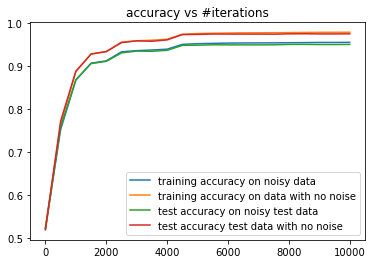

In [44]:
plt.plot(I, train_acc_noisy, label = 'training accuracy on noisy data')
plt.plot(I, train_acc, label = 'training accuracy on data with no noise')
plt.plot(I, test_acc_noisy, label = 'test accuracy on noisy test data')
plt.plot(I, test_acc, label = 'test accuracy test data with no noise')
plt.title("accuracy vs #iterations", color='black') 
plt.legend()
plt.show()